In [1]:
#Import all necessary libraries
import glob
import pandas as pd
import numpy as np

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import fastparquet
import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

import re
import random
import collections
import seaborn as sns

from gensim import corpora, models
import gensim
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats

pyLDAvis.enable_notebook()
random.seed(1234)

from sklearn.metrics.cluster import adjusted_rand_score
pd.options.display.max_columns = None

# 1. Topic Model on CommonCrawl


## 1.1. Loading and Filtering the Data
There are 28 files with ~2500 records each. 

In [2]:
%%time
#Load the parquet files into a single dataframe

result = pd.DataFrame()
#for filename in os.listdir("C:\\tmp\\my.tar\\istjoscha_cc_warc_wat_wet_acht_lang"):
for pth in sorted(glob.glob("D://HDa/TWM/Jupyter/data/*")):
    ds = pd.read_parquet(pth)
    print(pth)
    print(ds.shape)
    result = result.append(ds)
    print(result.shape)

#In case you are running out of memory, try to run the filter in the following paragraph on ds before appending

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D://HDa/TWM/Jupyter/data\part-00000-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2250, 8)
(2250, 8)
D://HDa/TWM/Jupyter/data\part-00001-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2250, 8)
(4500, 8)
D://HDa/TWM/Jupyter/data\part-00002-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2250, 8)
(6750, 8)
D://HDa/TWM/Jupyter/data\part-00003-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2250, 8)
(9000, 8)
D://HDa/TWM/Jupyter/data\part-00004-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2250, 8)
(11250, 8)
D://HDa/TWM/Jupyter/data\part-00005-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2500, 8)
(13750, 8)
D://HDa/TWM/Jupyter/data\part-00006-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2500, 8)
(16250, 8)
D://HDa/TWM/Jupyter/data\part-00007-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(2500, 8)
(18750, 8)
D://HDa/TWM/Jupyter/data\part-00008-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet

In [3]:
#filter on English and university-related content
result = result.loc[(result['Guessed-Language']=='en') & (result['Plaintext'].str.contains("niversity"))]

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1.2 Constructing the Corpus and Building the Model

In [4]:
#auxiliary function for "straight-forward" natural language preprocessing

def cleanup_text(record):
    text = record['Plaintext']
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any',
                      u'are', u'arent', u'as', u'at',
                      u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by',
                      u'can', 'cant', 'come', u'could', 'couldnt',
                      u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during',
                      u'each',
                      u'few', 'finally', u'for', u'from', u'further',
                      u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here',
                      u'hers', u'herself', u'him', u'himself', u'his', u'how',
                      u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself',
                      u'just',
                      u'll',
                      u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself',
                      u'no', u'nor', u'not', u'now',
                      u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves',
                      u'out', u'over', u'own',
                      u'r', u're',
                      u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such',
                      u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then',
                      u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too',
                      u'under', u'until', u'up',
                      u'very',
                      u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while',
                      u'who', u'whom', u'why', u'will', u'with', u'wont', u'would',
                      u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-Z0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if
                len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out


C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
%%time
#build gensim corpus

result=result.reset_index()
texts=[]
for index, row in result.iterrows():
    texts.append(cleanup_text(row))

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in texts]

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 25.4 s


In [6]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1/15, random_state=1)


C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 1min 7s


## 1.3 Inspecting the Results

In [7]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)


C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 19 s


In [10]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.005*"source" + 0.005*"research" + 0.005*"data" + 0.004*"care" + 0.004*"college" + 0.004*"authors" + 0.004*"presentation" + 0.004*"journal"'),
 (1,
  '0.015*"download" + 0.005*"thin" + 0.004*"films" + 0.004*"magnetic" + 0.003*"research" + 0.003*"book" + 0.003*"film" + 0.003*"international"'),
 (2,
  '0.009*"june" + 0.009*"july" + 0.009*"2017" + 0.007*"february" + 0.007*"january" + 0.007*"march" + 0.007*"october" + 0.007*"september"'),
 (3,
  '0.004*"people" + 0.003*"business" + 0.003*"best" + 0.003*"life" + 0.002*"free" + 0.002*"make" + 0.002*"day" + 0.002*"back"'),
 (4,
  '0.010*"school" + 0.010*"college" + 0.008*"ago" + 0.005*"state" + 0.004*"high" + 0.004*"elementary" + 0.004*"years" + 0.003*"day"'),
 (5,
  '0.003*"free" + 0.003*"design" + 0.003*"data" + 0.002*"share" + 0.002*"2017" + 0.002*"years" + 0.002*"dad" + 0.002*"download"'),
 (6,
  '0.036*"architects" + 0.012*"health" + 0.009*"public" + 0.007*"name" + 0.006*"english" + 0.004*"form" + 0.004*"board" + 0.003*"city"'),

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


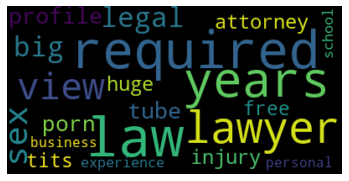

Adult Topic Id = 7


In [11]:
# create a wordcloud for topic: adult content


# get the top topic for a known adult content document 
docTopTopics = [maxTop(x) for x in ldamodelnormal.get_document_topics(corpus)]
adultTopicId = docTopTopics[15]
# adultTopicId = 14

#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[adultTopicId,i]


# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Adult Topic Id = " + str(adultTopicId))

In [12]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.022398 -0.057067       1        1   4.093049
1      0.062898  0.003100       2        1   8.271947
2     -0.038283  0.027312       3        1   7.652362
3     -0.037484  0.035701       4        1  13.628442
4     -0.083630 -0.021533       5        1   8.952391
5      0.014266 -0.005650       6        1   2.926578
6     -0.010159  0.040611       7        1   3.928343
7     -0.024620  0.022241       8        1   3.311665
8     -0.034281  0.025841       9        1   4.041708
9      0.153347  0.015513      10        1  14.698741
10    -0.024196 -0.086518      11        1   5.715696
11     0.087730  0.018149      12        1   4.187208
12    -0.057951  0.059305      13        1   5.664548
13    -0.017449  0.000845      14        1  10.992780
14    -0.012587 -0.077850      15        1   1.934543, topic_info=             Term         Freq        Total Category  logprob  loglift
11676  architects  5185.000000  5185.000000  Default  30.0000  30.0000
10371        temp  3828.000000  3828.000000  Default  29.0000  29.0000
9200          max  2300.000000  2300.000000  Default  28.0000  28.0000
528           min  2281.000000  2281.000000  Default  27.0000  27.0000
281      download  6012.000000  6012.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1526         care   159.031535  3200.538850  Topic15  -5.9732   0.9433
1209        floor   102.817448   500.858412  Topic15  -6.4093   2.3619
1792      million   111.776377  1085.347537  Topic15  -6.3258   1.6721
875          view   122.750180  4462.506672  Topic15  -6.2322   0.3520
849           two   114.762127  4218.279357  Topic15  -6.2994   0.3410

[1153 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12427      1  0.010907   039
12427      2  0.643514   039
12427      3  0.010907   039
12427      4  0.032721   039
12427      5  0.010907   039
...      ...       ...   ...
2044      11  0.030291  york
2044      12  0.012039  york
2044      13  0.067183  york
2044      14  0.055921  york
2044      15  0.020194  york

[12165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [13]:
pd.set_option('display.max_colwidth', -1)
df = pd.concat([result['Target-URI'], dfnormal], axis=1)
df.head(20)

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-8efea169867a>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288454,0.036900,0.385989,0.286921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.114020,NaN,0.882787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050193,NaN,NaN,NaN,0.102361,NaN,0.828880,0.011494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315398,0.021737,NaN,NaN,0.647754,NaN,NaN,NaN,0.013230,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550518,NaN,NaN,NaN,0.153652,NaN,0.292664,NaN,NaN,NaN,NaN,NaN
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.632491,NaN,0.355290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561684,0.437682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449497,NaN,0.550451,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,NaN,0.124489,0.601398,NaN,NaN,0.040909,0.042646,NaN,NaN,NaN,0.188532,NaN,NaN,NaN


C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


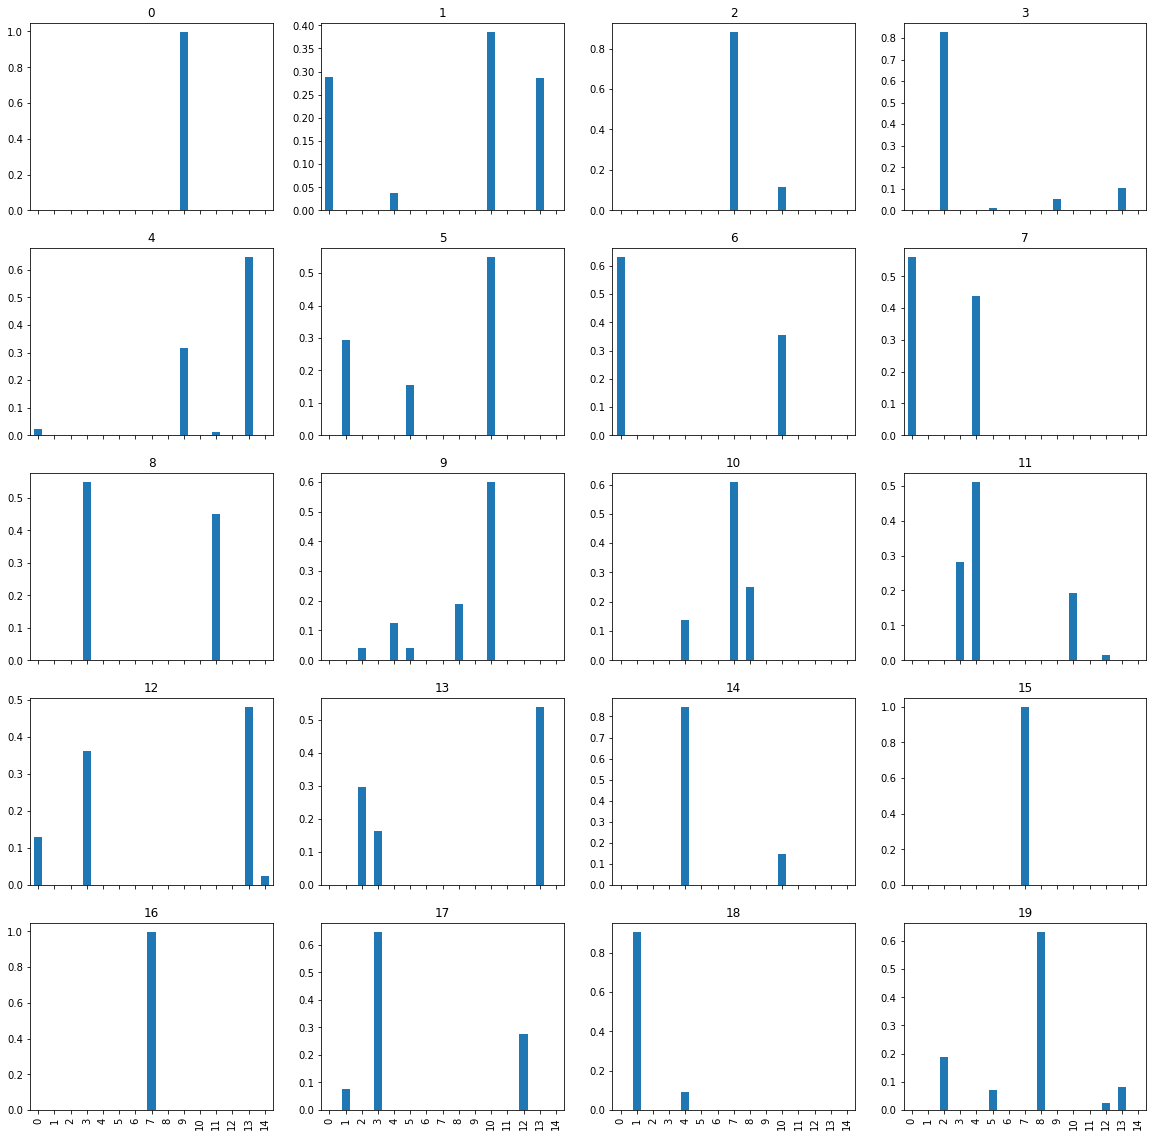

In [14]:
df_plot = df.drop('Target-URI', axis=1).head(20).transpose().sort_index()

fig, axes = plt.subplots(5, 4, sharex=True, sharey=True, figsize=(20,20))

index = 0
for ax in axes.flatten():
    df_plot[index].plot.bar(ax=ax)
    ax.set_title(index)
    index += 1

In [15]:
#inspect first 20 documents and their topic distributions
df = df[df[7].isna() | (df[7] < 0.5)]
df.head(20)

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288454,0.036900,0.385989,0.286921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050193,NaN,NaN,NaN,0.102361,NaN,0.828880,0.011494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315398,0.021737,NaN,NaN,0.647754,NaN,NaN,NaN,0.013230,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550518,NaN,NaN,NaN,0.153652,NaN,0.292664,NaN,NaN,NaN,NaN,NaN
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.632491,NaN,0.355290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561684,0.437682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449497,NaN,0.550451,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,NaN,0.124489,0.601398,NaN,NaN,0.040909,0.042646,NaN,NaN,NaN,0.188532,NaN,NaN,NaN
11,http://agmaturedatingyroi.localpolitics101.us/christian-single-men-in-fox-lake.html,NaN,NaN,0.512123,0.192266,NaN,NaN,NaN,NaN,NaN,NaN,0.280197,NaN,0.013918,NaN,NaN


In [16]:
df_topic = df[["Target-URI", 2, 11]]
df_topic = df_topic[(df[2] > 0.4) & (df[11] > 0.4)]
df_topic.head(10)

C:\ProgramData\Anaconda3\envs\twm_p4\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Target-URI,2,11
651,http://ess121.blogspot.com/2013/05/betta-fish-rwi1-final-week.html,0.439459,0.456721
